In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# --- 1. Charger le NetCDF ---
ds = xr.open_dataset("era5_t2m_20250101_fr.nc")
var_name = "t2m"   # à adapter si besoin

print(ds)

# --- 2. Extraire les lat/lon ---
lats = ds["latitude"].values   # (n_lat,)
lons = ds["longitude"].values  # (n_lon,)

# --- 3. Charger la France (shapefile) ---
france = gpd.read_file("../daaata/region.shx")   # ton fichier
gdf = france.to_crs("EPSG:4326")                 # WGS84

# Union de tous les polygones France
france_poly = gdf.unary_union

# --- 4. Construire la grille de points centres des pixels ---
lon2d, lat2d = np.meshgrid(lons, lats)  # lon: axe x, lat: axe y

# Aplatir pour test point-in-polygon
points = [Point(x, y) for x, y in zip(lon2d.ravel(), lat2d.ravel())]

# ⚠️ Lent mais fait une fois, pas par heure
mask_flat = np.array([france_poly.contains(p) for p in points])
mask = mask_flat.reshape(lat2d.shape)  # (n_lat, n_lon)

# --- 5. Appliquer le masque à tout le champ t2m (toutes les heures) ---
t2m = ds[var_name]   # (valid_time, latitude, longitude)
t2m_fr = t2m.where(mask)  # NaN en dehors de la France

<xarray.Dataset> Size: 257kB
Dimensions:     (valid_time: 24, latitude: 43, longitude: 62)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 192B 2025-01-01 ... 2025-01-01T23...
  * latitude    (latitude) float64 344B 51.5 51.25 51.0 ... 41.5 41.25 41.0
  * longitude   (longitude) float64 496B -5.5 -5.25 -5.0 -4.75 ... 9.25 9.5 9.75
    expver      (valid_time) <U4 384B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 256kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-06T10:55 GRIB to CDM+CF via cfgrib-0.9.1...


/var/folders/0f/_fg7x2451bj2lywhltbl4j3w0000gn/T/ipykernel_23164/1913984651.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_poly = gdf.unary_union


In [20]:
# --- 6. Conversion en °C si nécessaire ---
units = ds[var_name].attrs.get("units", "")
if units in ["K", "kelvin"]:
    t2m_fr_c = t2m_fr - 273.15
    units_plot = "°C"
else:
    t2m_fr_c = t2m_fr
    units_plot = units

# --- 7. Moyenne spatiale à chaque instant ---
# mean() ignore les NaN par défaut => parfait avec le mask
t2m_mean_series = t2m_fr_c.mean(dim=("latitude", "longitude"))

print(t2m_mean_series)

<xarray.DataArray 't2m' (valid_time: 24)> Size: 96B
array([1.7089728, 1.5970751, 1.5445999, 1.5164442, 1.5312752, 1.55048  ,
       1.5662639, 1.6515627, 1.8912532, 3.093762 , 4.441176 , 5.9134126,
       7.144537 , 8.013769 , 8.40594  , 8.086237 , 7.0182085, 6.026579 ,
       5.630231 , 5.446904 , 5.316586 , 5.2340183, 5.1935835, 5.1359906],
      dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 192B 2025-01-01 ... 2025-01-01T23...
    expver      (valid_time) <U4 384B ...


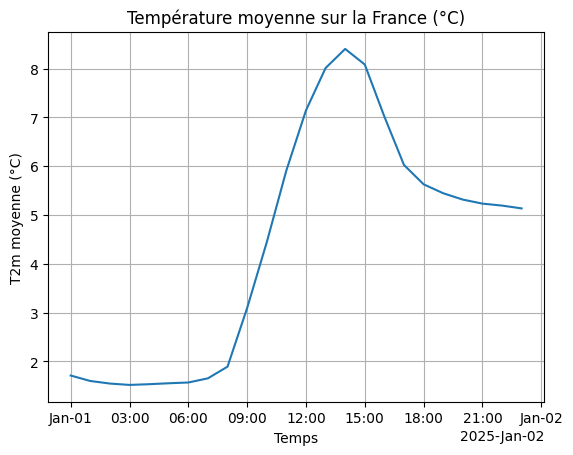

In [18]:
plt.figure()
t2m_mean_series.plot()
plt.title(f"Température moyenne sur la France ({units_plot})")
plt.xlabel("Temps")
plt.ylabel(f"T2m moyenne ({units_plot})")
plt.grid(True)
plt.show()

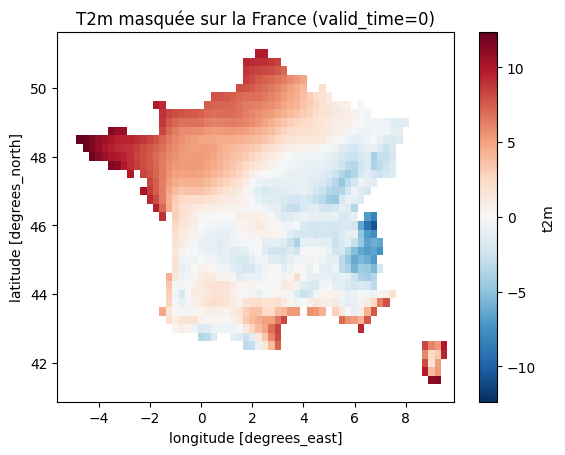

In [19]:
da = t2m_fr_c.isel(valid_time=0)
plt.figure()
da.plot()
plt.title("T2m masquée sur la France (valid_time=0)")
plt.show()